## **0. [Predict Future Sales - Kaggle Competition](https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data)**

*Informacje z Kaggle:* 

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

This dataset is permitted to be used for any purpose, including commercial use.

In [1]:
import os
os.chdir('..')

In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## 1. **Dane**
Zbiór danych składa się z 6 plików CSV: 
- sales_train.csv : dane historyczne sprzedazy produktów
- shops.csv: sklepy z nazwami
- item_categories.csv : kategorie produktów
- items.csv : produkty z nazwą, ID i ID kategorii
- test.csv : zbiór testowy na którym będzie sprawdzana skuteczność w Kaggle. Zawiera jedynie ID sklepu i produktu.
- sample_submission.csv : plik przedstawiający jak powinien wyglądać plik z predykcjami wrzucany do Kaggle.

In [6]:
"""
- dane w przedziale 2013-01-01 do 2015-10-31
- kolumna date_block_num - numer miesiąca w calym zbiorze (od 0 do 33)
- kolumna shop_id - unikalny identyfikator sklepu
- kolumna item_id - unikalny identyfikator produktu
- kolumna item_price - cena produktu, nieznormalizowana
- kolumna item_cnt_day - liczba sprzedanych produktów. Tą wartość będziemy przewidywać.
"""
pd.read_csv(".data/base/sales_train.csv")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [7]:
"""
- kolumna shop_name - nazwa produktu, cyrylica, j. rosyjski
"""
pd.read_csv(".data/base/shops.csv").sample(5)

,shop_name,shop_id
20,"Москва ""Распродажа""",20
42,"СПб ТК ""Невский Центр""",42
4,"Волжский ТЦ ""Волга Молл""",4
37,"Новосибирск ТЦ ""Мега""",37
56,"Чехов ТРЦ ""Карнавал""",56


In [8]:
"""
- item_category_name - nazwa kategorii produktu, cyrylica, j. rosyjski
- niektore kategorie mogą wskazywać podobieństwo, np. PS2, PS3, PS4. Warto przetlumaczyc
"""
pd.read_csv(".data/base/item_categories.csv")

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [9]:
"""
- item_name - nazwa produktu, cyrylica, j. rosyjski
"""
pd.read_csv(".data/base/items.csv")

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [10]:
"""
- kolumna ID - identyfikator pary (sklep, produkt)
- Z Kaggle wiemy, że ten zbiór odnosi się do okresu 2015-11-01 do 2015-11-30, zatem bylby to date_block_num=34
- Inferencja odbywa się jedynie dla zadanego sklepu i produktu, nie posiadamy zadnej dodatkowej informacji, musimy je wywnioskować z danych treningowych
"""
pd.read_csv(".data/base/test.csv")

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [11]:
pd.read_csv(".data/base/sample_submission.csv")

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [12]:
df = pd.read_parquet(".data/data.parquet")

In [13]:
print(f"""
Statystyki liczności zbiorów zmiennych kategorycznych:
    - unique_shops: {df['shop_id'].nunique()}
    - unique_items: {df['item_id'].nunique()}
    - unique_categories: {df['item_category_id'].nunique()}
""")


Statystyki liczności zbiorów zmiennych kategorycznych:
    - unique_shops: 60
    - unique_items: 22170
    - unique_categories: 84



In [15]:
"""
W zbiorze nie występują dane brakujące, kazda kolumna ma prawidłowe wartości
"""
# df.isna().any(axis=0)

'\nW zbiorze nie występują dane brakujące, kazda kolumna ma prawidłowe wartości\n'

In [16]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_month,city_id,item_category_id,general_item_category_id
count,3.150049e+06,3.150049e+06,3.150049e+06,2.935849e+06,2.935849e+06,3.150049e+06,3.150049e+06,3.150049e+06,3.150049e+06
mean,1.589114e+01,3.290933e+01,1.025313e+04,8.908532e+02,1.242641e+00,5.570867e+00,1.506304e+01,4.043034e+01,9.961043e+00
std,1.032864e+01,1.632479e+01,6.322838e+03,1.729800e+03,2.618834e+00,3.617431e+00,7.861710e+00,1.714860e+01,3.491220e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.510000e+03,2.490000e+02,1.000000e+00,2.000000e+00,1.200000e+01,2.900000e+01,8.000000e+00
50%,1.500000e+01,3.100000e+01,9.461000e+03,3.990000e+02,1.000000e+00,6.000000e+00,1.400000e+01,4.000000e+01,1.100000e+01
75%,2.400000e+01,4.700000e+01,1.572700e+04,9.990000e+02,1.000000e+00,9.000000e+00,2.100000e+01,5.500000e+01,1.300000e+01
max,3.400000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,1.100000e+01,3.000000e+01,8.300000e+01,1.900000e+01


In [17]:
"""
- Wszystkie kolumny kategoryczne (date_block_num, shop_id, item_id, item_category_id) mają typ int64,
co jest zgodne z oczekiwaniami, nie występują wartości niezgodne z typem.
- Kolumny tesktowe (shop_name, item_name, item_category_name) mają typ object, co również jest zgodne z oczekiwaniami.
- Zmienne numeryczne (item_price, item_cnt_day) mają typ float64, typ się zgadza.
- Kolumna date była poprawnie zrzutowana z uzyciem `pd.to_datetime` na typ datetime64[ns], nie ma błędów.

Wniosek: dane są poprawne, nie jest potrzebna konwersja typów oraz sprawdzanie, czy dane nie mają błędów w zapisie.
"""
df.dtypes

date                            object
date_block_num                   int64
shop_id                          int64
item_id                          int64
item_price                     float64
item_cnt_day                   float64
date_month                       int64
shop_name                       object
shop_name_en                    object
city                            object
shop_name_direct                object
city_id                          int64
item_name                       object
item_category_id                 int64
item_category_name              object
item_category_name_en           object
general_item_category_name      object
specific_item_category_name     object
general_item_category_id         int64
dtype: object

## 2.1 **Analiza wartości odstających**

<Axes: xlabel='item_price'>

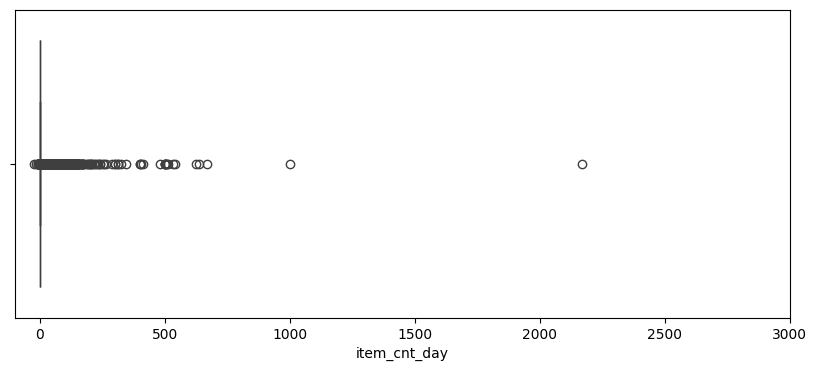

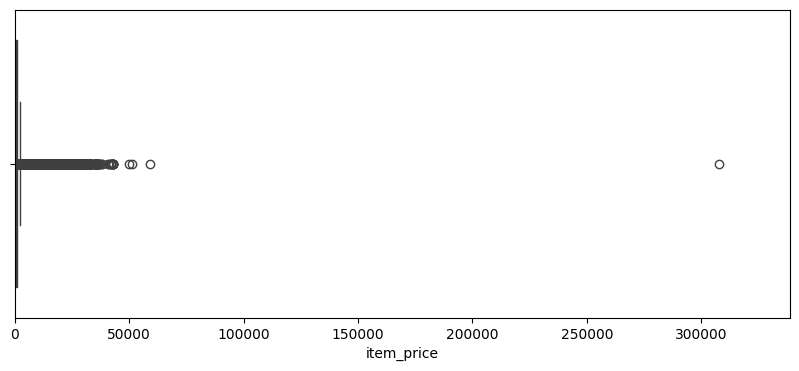

In [19]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=df.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(df.item_price.min(), df.item_price.max()*1.1)
sns.boxplot(x=df.item_price)

Z (jednostronnych) box plotów widac wartosci odstajace dla `item_cnt_day` (~ >1000) oraz `item_price` (~ >60000). 
Wartosci te zostana odfiltrowane w fazie budowania cech.

In [21]:
df[df.item_price <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_month,shop_name,shop_name_en,city,shop_name_direct,city_id,item_name,item_category_id,item_category_name,item_category_name_en,general_item_category_name,specific_item_category_name,general_item_category_id
1645106,15.05.2013,4,32,2973,-1.0,1.0,4,"Москва ТЦ ""Серебряный Дом""",Moscow Silver House Mall,Moscow,Silver House Mall,14,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,Games - PS3,Games,PS3,5


Istnieje jeden rekord z ceną równą -1. Nalezy go usunąć, lub imputowac dowolna technika (np. mean, median itp.)

In [ ]:
df.loc[df.shop_id.isin([0, 57]), ['shop_id', 'shop_name', 'shop_name_en']].apply(pd.Series.unique)

,shop_id,shop_name,shop_name_en
0,0,"!Якутск Орджоникидзе, 56 фран","Yakutsk Ordzhonikidze, 56 Franchise"
1,57,"Якутск Орджоникидзе, 56","Yakutsk Ordzhonikidze, 56"


In [32]:
df.loc[df.shop_id.isin([1, 58]), ['shop_id', 'shop_name', 'shop_name_en']].apply(pd.Series.unique)

,shop_id,shop_name,shop_name_en
0,1,"!Якутск ТЦ ""Центральный"" фран",Yakutsk Central Mall Franchise
1,58,"Якутск ТЦ ""Центральный""",Yakutsk Central Mall


In [33]:
df.loc[df.shop_id.isin([10, 11]), ['shop_id', 'shop_name', 'shop_name_en']].apply(pd.Series.unique)

,shop_id,shop_name,shop_name_en
0,10,Жуковский ул. Чкалова 39м?,Zhukovsky Chkalov St 39m?
1,11,Жуковский ул. Чкалова 39м²,Zhukovsky Chkalov St 39m²


Nastepujace pary sklepów są najprawdpodobniej tymi samymi sklepami o rownych identyfikatorach. 
Kazdy z nich zostanie przypisany do jednej wartosci z pary.
- `(0, 57)`
- `(1, 58)`
- `(10, 11)`

In [ ]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## 2.2 **Analiza cech**
Kazda cecha zostanie przeanalizowana pod kątem wskazania jej cech. Dla zmiennych kategorycznych wskazane będą liczność wraz z wykresami. Dla zmiennych numerycznych wskazane będą ich rozkłady.

In [ ]:
def categorical_analysis(df, column):
    """
    Funkcja zwraca statystyki dla kolumny kategorycznej
    """
    vc = df[column].value_counts()
    vc_norm = vc / vc.sum()
    return pd.DataFrame({'count': vc, 'norm_count': vc_norm})

def categorical_plot(df_analysis, column):
    """
    Funkcja rysuje wykres słupkowy dla analizy kategorycznej
    """
    plt.figure(figsize=(12, 5))
    plt.bar(df_analysis.index, df_analysis['count'])
    plt.title(f'Bar frequency plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
categorical_analysis_shop_id = categorical_analysis(df_train, 'shop_id')
display(categorical_analysis_shop_id)
categorical_plot(categorical_analysis_shop_id, 'shop_id')

In [ ]:
categorical_analysis_item_id = categorical_analysis(df_train, 'item_id')
display(categorical_analysis_item_id)
categorical_plot(categorical_analysis_item_id, 'item_id')

In [ ]:
categorical_analysis_item_category_id = categorical_analysis(df_train, 'item_category_id')
display(categorical_analysis_item_category_id)
categorical_plot(categorical_analysis_item_category_id, 'item_category_id')

In [ ]:
categorical_analysis_date_block_num = categorical_analysis(df_train, 'date_block_num')
display(categorical_analysis_date_block_num)
categorical_plot(categorical_analysis_date_block_num, 'date_block_num')

In [ ]:
def numerical_analysis(df, column):
    """
    Funkcja zwraca statystyki dla kolumny kategorycznej
    """
    vc = df[column].value_counts()
    vc_norm = vc / vc.sum()
    return pd.DataFrame({'count': vc, 'norm_count': vc_norm})

def numerical_plot(df_analysis, column, bins=None):
    """
    Funkcja rysuje wykres słupkowy dla analizy kategorycznej
    """
    plt.figure(figsize=(12, 5))
    plt.hist(df_analysis[column], bins=bins)
    plt.title(f'Hist plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
numerical_plot(df_train, 'item_price')

In [ ]:
numerical_plot(df_train, 'item_cnt_month')

## 3. **Zaawansowana Analiza cech**


In [ ]:
df_train.groupby('shop_id')['item_id'].nunique().sort_values(ascending=False) 

In [ ]:
df_train.groupby('item_category_id')['item_id'].nunique().sort_values(ascending=False)

In [ ]:
df_train.groupby("item_category_id")['item_price'].mean().sort_values(ascending=False)

In [ ]:
"""
Histogramy średniej ceny artykułów w kazdej kategorii wskazują (wizualnie)
na silne powiazanie tych dwoch atrybutow. Średnia cena artykułu w danej
kategorii moze byc potencjalną cechą otrzymaną w procesie inzynierii
cech.
"""

unique_categories = np.sort(df_train['item_category_id'].unique())

plt.figure(figsize=(20, 200))
for i, category in enumerate(unique_categories, 1):
    plt.subplot(len(unique_categories) // 2 + 1, 2, i)
    category_data = df_train[df_train['item_category_id'] == category]['item_price']
    category_data.hist(bins=50)
    mean_price = category_data.mean()
    plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_price:.2f}')
    plt.title(f'Category {category} (n={len(category_data)})')
    plt.xlabel('Item Price')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
"""
Miesięczna suma sprzedazy we wszystkich sklepach spada zgodnie z jakims trendem.
Osiaga piki, najprawdopodobniej co określony interwał czasowy. Być moze miesiac
w ktorym przypada zbior testowy rowniez bedzie posiadal taki pik. Nalezy na to
zwrocic uwage.
"""

plt.figure(figsize=(20, 8))
monthly_sales_aggregated = df_train.groupby("date_block_num")['item_cnt_month'].sum()
monthly_sales_aggregated.plot()
plt.title('Monthly Sales Aggregated')
plt.xlabel('Consecutive months')
plt.ylabel('Sum per month')
plt.legend()


In [ ]:
"""
Nie wszystkie sklepy są notowane kazdego miesiąca, jest to problem, ktory będzie musiał
zostać rozwiązany podczas przewidywania, poniewaz przy podziale datasetu na treningowy/
walidacyjny/testowy będziemy uzywac odcięcia czasowego, tj. dane z wczesniejszych miesiecy
beda uzywane do trenowania modelu uzywanego do pozniejszych miesiecy. Jesli sklep nie pojawi
sie w poprzednich miesiacach, a będzie w zbiorze do predykcji to będziemy musieli wnioskowac
na bazie innych sklepów i artykułów.
"""

monthly_sales_per_shop = df_train.groupby(["shop_id", "date_block_num"])['item_cnt_month'].sum()
monthly_sales_per_shop_matrix = monthly_sales_per_shop.unstack().to_numpy()

fig, ax = plt.subplots(monthly_sales_per_shop_matrix.shape[0] // 2, 2, figsize=(20, 200))
for i in range(monthly_sales_per_shop_matrix.shape[0]):
    m, n = (i // 2), (i % 2)
    ax[m, n].plot(monthly_sales_per_shop_matrix[i], marker='o')
    ax[m, n].axhline(np.nanmean(monthly_sales_per_shop_matrix[i]), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.nanmean(monthly_sales_per_shop_matrix[i]):.2f}')
    ax[m, n].axhline(np.nanmin(monthly_sales_per_shop_matrix[i]), color='blue', linestyle='dashed', linewidth=1, label=f'Min: {np.nanmin(monthly_sales_per_shop_matrix[i]):.2f}')
    ax[m, n].axhline(np.nanmax(monthly_sales_per_shop_matrix[i]), color='blue', linestyle='dashed', linewidth=1, label=f'Max: {np.nanmax(monthly_sales_per_shop_matrix[i]):.2f}')
    ax[m, n].set_xlim(-1, 35)
    ax[m, n].set_ylim(min(0, np.nanmin(monthly_sales_per_shop_matrix[i])), 1.1 * np.nanmax(monthly_sales_per_shop_matrix[i]))
    ax[m, n].grid(True)
    ax[m, n].set_title(f'Monthly Sales Shop={i}')
    ax[m, n].set_xlabel('Consecutive months')
    ax[m, n].set_ylabel('Sum per month')
    ax[m, n].legend()

plt.tight_layout()
plt.show()

In [ ]:
"""
Rozbiezność cen tego samego produktu w róznych sklepach.
Wartość przedstawia odsetek produktów dla których cena rózni sie
miedzy sklepami. 
Wniosek: nie mozemy zakladać ze jeśli produkt był sprzedany w jednym sklepie 
po danej cenie, to w innym sklepie będzie sprzedawany po tej samej.
Musimy przyjąć jakąś metodę szacowania ceny. Jest to równiez 
miejsce na potencjalą inzynierie cech
"""
(df_train[['item_id', 'item_price']].groupby("item_id")['item_price'].nunique().values > 1).mean() # type: ignore

In [ ]:
"""
Rozbiezność cen tego samego produktu w tym samym sklepie.
Innymi słowy zmienność ceny produktu.
Wartość przedstawia odsetek produktów dla ktorych tena rózni
się w tym samym sklepie (na przestrzeni czasu).
"""
(df_train[['shop_id', 'item_id', 'item_price']].groupby(['shop_id', "item_id"])['item_price'].nunique().values > 1).mean() # type: ignore

## x. **Rózne testy**

In [ ]:
df_full

In [ ]:
"""
Liczba nowych wartości dodawanych do zbioru danych na przestrzeni czasu. 
Z (prawie) kazdym miesiącem przybywa sklepów, produktów i kategorii.

Wniosek: nalezy stworzyć metodę przetwarzania dla nowych wartości.
"""

cat_columns = ['shop_id', 'item_id', 'item_category_id']
date_blocks_num = sorted(list(df_full['date_block_num'].unique()))[1:]

diff_sizes = {col: [] for col in cat_columns}

for date in date_blocks_num:
    df_date_train = df_full[df_full['date_block_num'] < date]
    df_date_valid = df_full[df_full['date_block_num'] == date]

    print(f"Date_block_num: {date}")

    for column in cat_columns:
        train_uq = df_date_train[column].unique()
        valid_uq = df_date_valid[column].unique()
        diff = np.setdiff1d(valid_uq, train_uq)
        diff_sizes[column].append(diff.size)
        print(f"\tColumn: {column} \n\tDiff: {diff} (size {diff.size})\n")

# Plotting the diff sizes for each categorical column
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

for i, column in enumerate(cat_columns):
    ax[i].plot(date_blocks_num, diff_sizes[column], label=column)
    ax[i].legend()
    ax[i].grid(True)
    ax[i].set_xticks(date_blocks_num)  # Set ticks to 1
    ax[i].set_xticklabels(date_blocks_num, rotation=90)  # Rotate labels for better readability
    
plt.xlabel('Date Block Number')
plt.ylabel('Number of Diff Values')
plt.title('Number of Diff Values Size for Each Categorical Column Over Time')
plt.show()


In [ ]:
def check_value_set_difference_dfs(df1, df2, col):
    """Check what fraction of the values in col in df1 (test) are included in df2 (train). Returns difference values."""
    df1_uq = df1[col].unique()
    df2_uq = df2[col].unique()

    overlap_index = np.isin(df1_uq, df2_uq)
    print(f"{overlap_index.mean()} values from {col} in test are present in train")
    print("Length of non-overlapping values in test:", (~overlap_index).sum())

    return df1_uq[~overlap_index]

_df_test = pd.read_csv(".data/test.csv")
_df = pd.read_csv(".data/sales_train.csv")
check_value_set_difference_dfs(_df_test, _df, "shop_id")
check_value_set_difference_dfs(_df_test, _df, "item_id")

## x. **Zapisanie utworzonych danych do pliku w formacie `parquet`**

In [ ]:
display(df_train)

In [ ]:
display(df_full)

In [ ]:
df_train.to_parquet(".data/df_train.parquet")
df_test.to_parquet(".data/df_test.parquet")
df_full.to_parquet(".data/df_full.parquet")